In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import random
import os
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
import lifelines.statistics 

sns.set_theme()
sns.set_context("notebook")
sns.set_palette("colorblind")

# Bernard et al.

In [2]:
#define path to data
data_path = "../data/"
bernard = "BernardEtAl/"

#read the data
path_verylow = data_path+bernard+'veryLow.tsv'
df_verylow = pd.read_csv(path_verylow, sep='\t')
path_low = data_path+bernard+'low.tsv'
df_low = pd.read_csv(path_low, sep='\t')
path_int = data_path+bernard+'int.tsv'
df_int = pd.read_csv(path_int, sep='\t')
path_high = data_path+bernard+'high.tsv'
df_high = pd.read_csv(path_high, sep='\t')
path_veryhigh = data_path+bernard+'veryHigh.tsv'
df_veryhigh = pd.read_csv(path_veryhigh, sep='\t')

# Add a column with the risk group to each of the dataframes
df_verylow['Risk Group'] = 'Very Low'
df_low['Risk Group'] = 'Low'
df_int['Risk Group'] = 'Intermediate'
df_high['Risk Group'] = 'High'
df_veryhigh['Risk Group'] = 'Very High'

# Concatenate the dataframes
df = pd.concat([df_verylow, df_low, df_int, df_high, df_veryhigh]).reset_index(drop=True)

df['Status'] = df['Status'].map({'censored': 0, 'deceased': 1})
#eliminate columns
df = df.drop(['Case ID', 'Study ID', 'Survival Rate', 'Number at Risk'], axis=1)
#raname columns
df = df.rename(columns={'Time (months)': 'Time'})

In [3]:
df

,Status,Time,Risk Group
0,0,0.000000,Very Low
1,0,0.000000,Very Low
2,0,0.000000,Very Low
3,0,0.000000,Very Low
4,0,0.000000,Very Low
...,...,...,...
2995,0,77.786301,Very High
2996,1,79.923288,Very High
2997,0,97.380822,Very High
2998,0,129.665753,Very High


## Macro Survival Analysis

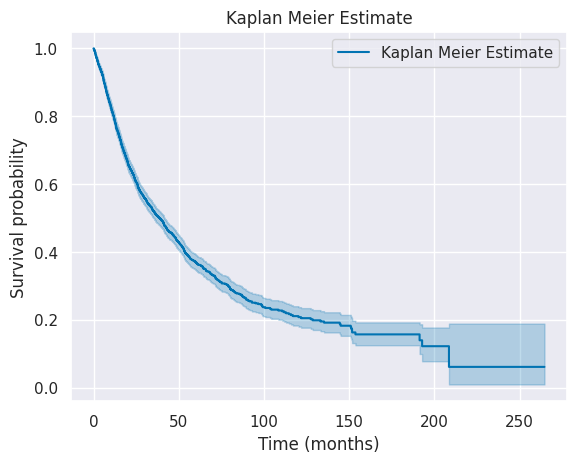

In [4]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df['Time'], event_observed = df['Status'], label = 'Kaplan Meier Estimate')

#plot the Kaplan Meier Estimate
kmf.plot(ci_show=False)
plt.title('Kaplan Meier Estimate')
plt.xlabel('Time (months)')
plt.ylabel('Survival probability')
plt.show()

In [5]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

In [6]:
#print median formatting .2f
print('Median survival time:', "{:.2f}".format(median_))
median_confidence_interval_

Median survival time: 38.76


,Kaplan Meier Estimate_lower_0.95,Kaplan Meier Estimate_upper_0.95
0.5,35.342466,41.556164


## Group Survival Analysis

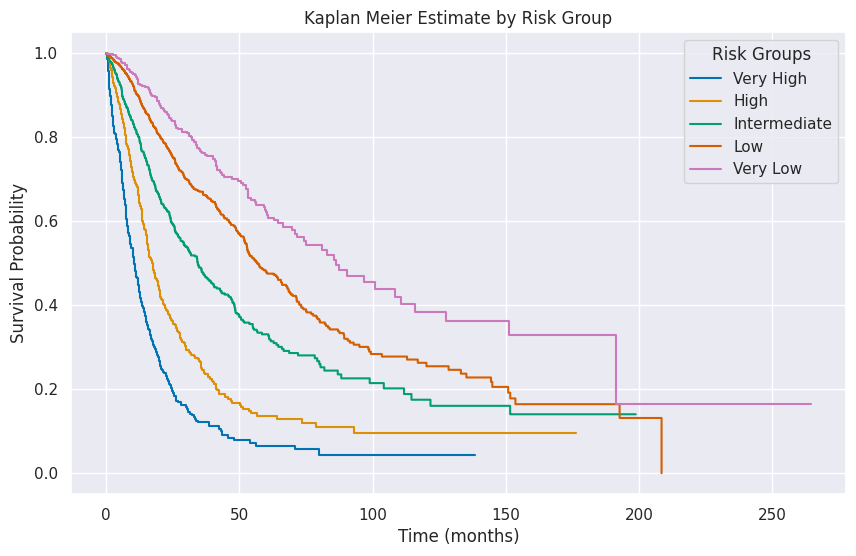

In [7]:
groups = df['Risk Group']
ix_vl = (groups == 'Very Low')
ix_l = (groups == 'Low')
ix_i = (groups == 'Intermediate')
ix_h = (groups == 'High')
ix_vh = (groups == 'Very High')

km = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Setting the figure size

# Fitting and plotting for each risk group
medians = []
medians_ci = []
for ix, label in zip([ix_vh, ix_h, ix_i, ix_l, ix_vl], ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']):
    km.fit(df['Time'][ix], df['Status'][ix], label=label)
    medians.append(km.median_survival_time_)
    medians_ci.append(median_survival_times(km.confidence_interval_))
    km.plot(ax=plt.gca(), ci_show=False)  # Use the current axes, overlaying the plots

plt.title('Kaplan Meier Estimate by Risk Group')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend(title='Risk Groups', loc = 'best')

plt.show()

In [8]:
for median, ci in zip(medians, medians_ci):
    print('Median survival time:', "{:.2f}".format(median))
    print(ci)

Median survival time: 10.52
     Very High_lower_0.95  Very High_upper_0.95
0.5              8.778082              12.19726
Median survival time: 17.29
     High_lower_0.95  High_upper_0.95
0.5        15.386301        19.463014
Median survival time: 34.39
     Intermediate_lower_0.95  Intermediate_upper_0.95
0.5                 29.09589                39.287671
Median survival time: 56.68
     Low_lower_0.95  Low_upper_0.95
0.5            52.8       65.589041
Median survival time: 86.10
     Very Low_lower_0.95  Very Low_upper_0.95
0.5            71.605479            110.69589


# Lin et al.

In [9]:
#define path to data
data_path = "../data/"
lin = "LinEtAl/"

#read the data
path_colon = data_path+lin+'colon.csv'

df = pd.read_csv(path_colon, sep=',')
#eliminate columns
df = df.drop(['rownames', 'id', 'study', 'rx', 'sex', 'age', 'obstruct', 'perfor', 'adhere', 'nodes', 'differ', 'surg', 'node4', 'etype'], axis=1)

##raname columns
df = df.rename(columns={'time': 'Time', 'status': 'Status', 'extent': 'Tumor Spread'})

df['Tumor Spread'] = df['Tumor Spread'].map({1: 'Submucosa', 2: 'Muscle', 3: 'Serosa', 4: 'Contiguous Structures'})

df['Time'] = df['Time']/30

In [10]:
df

,Status,Tumor Spread,Time
0,1,Serosa,50.700000
1,1,Serosa,32.266667
2,0,Serosa,102.900000
3,0,Serosa,102.900000
4,1,Muscle,32.100000
...,...,...,...
1853,1,Serosa,28.366667
1854,0,Serosa,69.066667
1855,0,Serosa,69.066667
1856,0,Serosa,60.666667


## Macro Survival Analysis

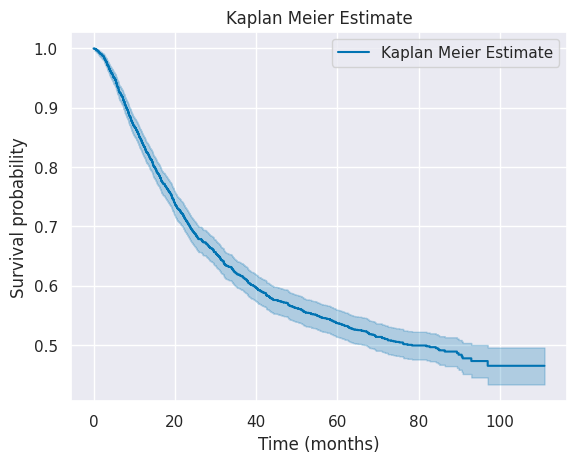

In [11]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df['Time'], event_observed = df['Status'], label = 'Kaplan Meier Estimate')

#plot the Kaplan Meier Estimate
kmf.plot(ci_show=False)
plt.title('Kaplan Meier Estimate')
plt.xlabel('Time (months)')
plt.ylabel('Survival probability')
plt.show()

In [12]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

In [13]:
#print median formatting .2f
print('Median survival time:', "{:.2f}".format(median_))
median_confidence_interval_

Median survival time: 78.37


,Kaplan Meier Estimate_lower_0.95,Kaplan Meier Estimate_upper_0.95
0.5,67.066667,97.0


## Group Survival Analysis

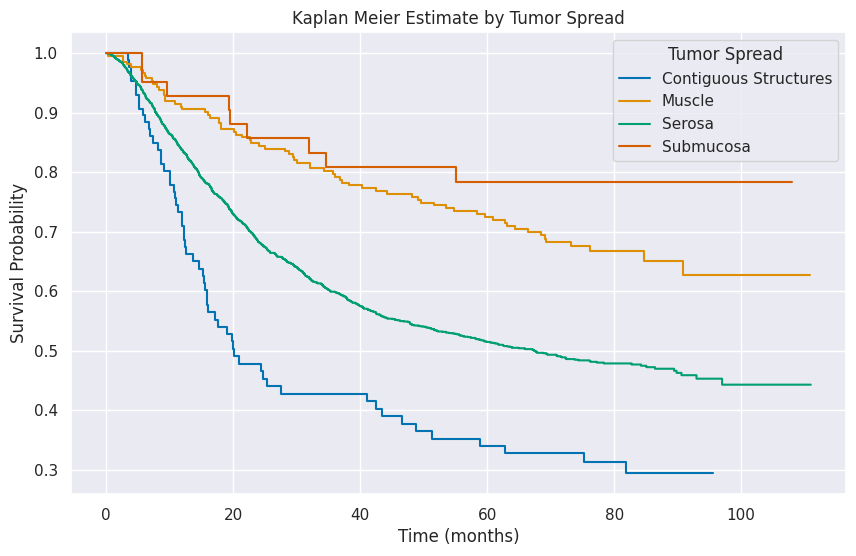

In [14]:
groups = df['Tumor Spread']
ix_submucosa = (groups == 'Submucosa')
ix_muscle = (groups == 'Muscle')
ix_serosa = (groups == 'Serosa')
ix_contiguous = (groups == 'Contiguous Structures')

km = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Setting the figure size

# Fitting and plotting for each risk group
medians = []
medians_ci = []
for ix, label in zip([ix_contiguous, ix_muscle, ix_serosa, ix_submucosa], ['Contiguous Structures', 'Muscle', 'Serosa', 'Submucosa']):
    km.fit(df['Time'][ix], df['Status'][ix], label=label)
    medians.append(km.median_survival_time_)
    medians_ci.append(median_survival_times(km.confidence_interval_))
    km.plot(ax=plt.gca(), ci_show=False)  # Use the current axes, overlaying the plots

plt.title('Kaplan Meier Estimate by Tumor Spread')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend(title='Tumor Spread', loc = 'best')

plt.show()

In [15]:
for median, ci in zip(medians, medians_ci):
    print('Median survival time:', "{:.2f}".format(median))
    print(ci)

Median survival time: 20.07
     Contiguous Structures_lower_0.95  Contiguous Structures_upper_0.95
0.5                         15.633333                         43.466667
Median survival time: inf
     Muscle_lower_0.95  Muscle_upper_0.95
0.5                inf                inf
Median survival time: 67.43
     Serosa_lower_0.95  Serosa_upper_0.95
0.5               55.7          85.066667
Median survival time: inf
     Submucosa_lower_0.95  Submucosa_upper_0.95
0.5                   inf                   inf


# Zehir et al.

In [16]:
#define path to data
data_path = "../data/"
zehir = "ZehirEtAl/"

#read the data
path_bladder = data_path+zehir+'bladder.tsv'
df_bladder = pd.read_csv(path_bladder, sep='\t')
path_breast = data_path+zehir+'breast.tsv'
df_breast = pd.read_csv(path_breast, sep='\t')
path_melanoma = data_path+zehir+'melanoma.tsv'
df_melanoma = pd.read_csv(path_melanoma, sep='\t')
path_thyroid = data_path+zehir+'thyroid.tsv'
df_thyroid = pd.read_csv(path_thyroid, sep='\t')


# Add a column with the risk group to each of the dataframes
df_bladder['Cancer Type'] = 'Bladder'
df_breast['Cancer Type'] = 'Breast'
df_melanoma['Cancer Type'] = 'Melanoma'
df_thyroid['Cancer Type'] = 'Thyroid'

# Concatenate the dataframes
df = pd.concat([df_bladder, df_breast, df_melanoma, df_thyroid]).reset_index(drop=True)

df['Status'] = df['Status'].map({'censored': 0, 'deceased': 1})
#eliminate columns
df = df.drop(['Case ID', 'Study ID', 'Survival Rate', 'Number at Risk'], axis=1)
#raname columns
df = df.rename(columns={'Time (months)': 'Time'})

In [17]:
df

,Status,Time,Cancer Type
0,1,0.66,Bladder
1,0,0.72,Bladder
2,0,0.76,Bladder
3,0,0.85,Bladder
4,0,0.89,Bladder
...,...,...,...
1556,0,32.81,Thyroid
1557,0,33.20,Thyroid
1558,0,33.50,Thyroid
1559,0,36.72,Thyroid


## Macro Survival Analysis

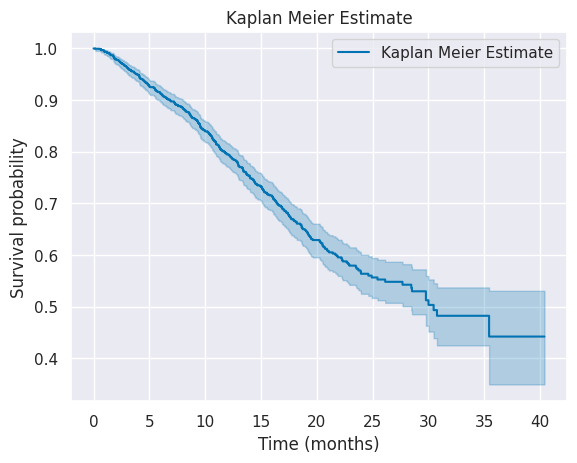

In [18]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df['Time'], event_observed = df['Status'], label = 'Kaplan Meier Estimate')

#plot the Kaplan Meier Estimate
kmf.plot(ci_show=False)
plt.title('Kaplan Meier Estimate')
plt.xlabel('Time (months)')
plt.ylabel('Survival probability')
plt.show()

In [19]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

In [20]:
#print median formatting .2f
print('Median survival time:', "{:.2f}".format(median_))
median_confidence_interval_

Median survival time: 30.47


,Kaplan Meier Estimate_lower_0.95,Kaplan Meier Estimate_upper_0.95
0.5,28.47,inf
